# 1. Introduction
EcoBici are shared bicycles available to the public in Buenos Aires city. The main aim of the Ecobici bike system is to reduce the sound/smog pollution from cars and reduce transportation cost. The city bikes were introduced in 2010 as a pilot project with only 4 bike stations available. After becoming popular among the citizens, Buenos Aires city council  decided to gradually expand the bike network. In the period between 2010 and 2019, more than 400 were added to the network. By 2019 the bike network reached the pick, but after lockdown many bike station were closed and nowdays around 300 bicycle stations are working. 
Here we are going to analyse the bike rides that take place between 2019 and 2023. Find what are the most popular stations and rides, what is the average duration ride, etc.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from keplergl import KeplerGl
from pyproj import CRS
import json
import os
import gc
from tqdm import tqdm

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = "data/"

# Custom Colors
COLORMAP = sns.cubehelix_palette(as_cmap=True)
COLOR_PALETTE = sns.color_palette("Set2")

WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [ ]:
def plotKeplerMap(kepler_map, height=600):
    orig_html = str(map_bike_trips._repr_html_(),'utf-8')
    b64d_html = base64.b64encode(orig_html.encode('utf-8')).decode('utf-8')
    framed_html = f'<iframe src="data:text/html;base64,{b64d_html}" style="width:95%; height: {height}px">'
    return IPython.display.HTML(framed_html)

# 2. Load dataset
`bike_share_baires` has information about each ride from 2019 to 2023. Here are the variables description from the dataset:

- *rout_id*: the route ID .
- *duration*: Amount of time that the ride takes (min). How long does it takes from the befining to the end of the ride.
- *departure*: Departure date and time.
- *departure_station_id*: Departure station ID.              
- *departure_station_name*: Departure bike station name.            
- *departure_address*: Departure bike station address.                  
- *departure_long*: The longitude coordinate from the departure bike station.                   
- *departure_lat*: The latitude coordinate from the departure bike station.                    
- *return*: Return date and time.                   
- *return_station_id*: Return bike station ID.            
- *return_station_name*: Destination bike station name.                
- *return_station_address*: Return bike station address.          
- *return_station_long*: The longitude coordinate from the return bike station.             
- *return_station_lat*: The latitude coordinate from the return bike station.             
- *user_id*: User Id.                    
- *bicycle_type*: Bicycle type name.                      
- *gender*: User gender.                           
- *year*: Current year we refert to.


In [5]:
df_bike_trip = pd.read_parquet(os.path.join(PATH, "bike_share_baires.parquet"))

We load Buenos Aires neighbourhoods polygons and coordinates data with their respective names

In [6]:
with open(os.path.join(PATH, 'baires-neighborhoods.geojson')) as f:
    neighborhoods = json.load(f) 

# 3. Exploring - Basic Analysis

In [6]:
df_bike_trip.head()

,rout_id,duration,departure,departure_station_id,departure_station_name,departure_address,departure_long,departure_lat,return,return_station_id,return_station_name,return_station_address,return_station_long,return_station_lat,user_id,bicycle_type,gender,year
0,9379BAEcobici,3.983333,2019-02-27 19:44:42,5BAEcobici,005 - Plaza Italia,Av. Sarmiento 2601,-58.420954,-34.580550,2019-02-27 19:48:41,5BAEcobici,005 - Plaza Italia,Av. Sarmiento 2601,-58.420954,-34.580550,6243BAEcobici,ICONIC,OTHER,2019
1,7441BAEcobici,46.900000,2019-02-27 14:35:58,6BAEcobici,006 - Parque Lezama,"Avenida Martin Garcia, 295",-58.369758,-34.628526,2019-02-27 15:22:52,6BAEcobici,006 - Parque Lezama,"Avenida Martin Garcia, 295",-58.369758,-34.628526,11140BAEcobici,ICONIC,MALE,2019
2,6828BAEcobici,4.966667,2019-02-27 11:51:40,73BAEcobici,073 - Ruy Díaz de Guzmán,Avenida Martin Garcia y Ruy Díaz de Guzmán,-58.371823,-34.630681,2019-02-27 11:56:38,6BAEcobici,006 - Parque Lezama,"Avenida Martin Garcia, 295",-58.369758,-34.628526,1994BAEcobici,ICONIC,MALE,2019
3,7485BAEcobici,38.733333,2019-02-27 14:45:57,59BAEcobici,018 - Independencia,Idependencia y Bernardo de Irigoyen,-58.380565,-34.617654,2019-02-27 15:24:41,9BAEcobici,009 - Parque Las Heras,"2300 Diaz, Cnel. Av. & French",-58.407741,-34.585443,2176BAEcobici,ICONIC,MALE,2019
4,6111BAEcobici,20.250000,2019-02-27 07:46:13,91BAEcobici,091 - Pasco,708 Pasco & Chile,-58.397602,-34.617448,2019-02-27 08:06:28,10BAEcobici,KP1808000368,"1600 Moreau De Justo, Alicia Av.",-58.365744,-34.616282,6056BAEcobici,ICONIC,FEMALE,2019


The dataset has the following structure and data type.

In [7]:
df_bike_trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15204523 entries, 0 to 15356595
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   rout_id                 object        
 1   duration                float64       
 2   departure               datetime64[ns]
 3   departure_station_id    object        
 4   departure_station_name  object        
 5   departure_address       object        
 6   departure_long          float64       
 7   departure_lat           float64       
 8   return                  datetime64[ns]
 9   return_station_id       object        
 10  return_station_name     object        
 11  return_station_address  object        
 12  return_station_long     float64       
 13  return_station_lat      float64       
 14  user_id                 object        
 15  bicycle_type            object        
 16  gender                  object        
 17  year                    category      
dtype

There are more than 15 Mill of bike trips which were made by 720 K users.

In [9]:
df_bike_trip.shape

(15204523, 18)

In [10]:
df_bike_trip.nunique()

rout_id                   15204523
duration                     48675
departure                 13504384
departure_station_id           457
departure_station_name         458
departure_address              466
departure_long                 464
departure_lat                  465
return                    13363626
return_station_id              457
return_station_name            458
return_station_address         466
return_station_long            494
return_station_lat             482
user_id                     721351
bicycle_type                     2
gender                           3
year                             5
dtype: int64

In [11]:
df_bike_trip.loc[:,["year","departure_long", "departure_lat", "return_station_long", "return_station_lat"]].groupby("year").describe()

departure_long                                                        \
              count       mean       std        min        25%        50%   
year                                                                        
2019      6121684.0 -58.423633  0.038063 -58.519781 -58.454304 -58.420954   
2020      2398401.0 -58.421610  0.034001 -58.519781 -58.446944 -58.420628   
2021      2841403.0 -58.419111  0.032561 -58.521740 -58.441607 -58.418731   
2022      2906499.0 -58.419298  0.036479 -58.526018 -58.444041 -58.415787   
2023       936536.0 -58.419541  0.037546 -58.526018 -58.445070 -58.416014   

                           departure_lat             ... return_station_long  \
            75%        max         count       mean  ...                 75%   
year                                                 ...                       
2019 -58.390836 -58.000000     6121684.0 -34.602283  ...          -58.390602   
2020 -58.395844 -58.355465     2398401.0 -34.598085  ...          -58.395844   
2021 -58.394464 -58.355465     2841403.0 -34.598346  ...          -58.394464   
2022 -58.390602 -58.355465     2906499.0 -34.598128  ...          -58.390602   
2023 -58.389973 -58.355465      936536.0 -34.599090  ...          -58.390089   

                return_station_lat                                             \
            max              count       mean       std        min        25%   
year                                                                            
2019 -58.000000          6121684.0 -34.602392  0.025952 -34.683188 -34.619380   
2020 -58.355465          2398401.0 -34.598219  0.024271 -34.683188 -34.614948   
2021 -58.355465          2841403.0 -34.598517  0.022603 -34.683188 -34.613636   
2022 -58.355465          2906499.0 -34.598227  0.022535 -34.683188 -34.613636   
2023 -58.355465           936536.0 -34.599120  0.023171 -34.681761 -34.615699   

                                       
            50%        75%        max  
year                                   
2019 -34.602667 -34.586632 -34.000000  
2020 -34.599068 -34.581576 -34.541901  
2021 -34.599036 -34.583749 -34.544503  
2022 -34.599068 -34.583749 -34.541000  
2023 -34.601173 -34.583749 -34.541000  

[5 rows x 32 columns]

# 4. Ride duration

The city bike system has grown significantly since 2016, and it has had its ups and downs since then. Despite that the service is not longer free and the concecuences of the covid-19 pandemic, the way in how the city bikes is used has not changed substantially.
If we look at the individual trips made in the last three and a half years, we will see that the average ride duration is around 30 minutes while the median ride duration is around 18 minutes. Given the right-skewed distribution of the data, the averages are slightly skewed and the majority of trips actually last from 8–12.


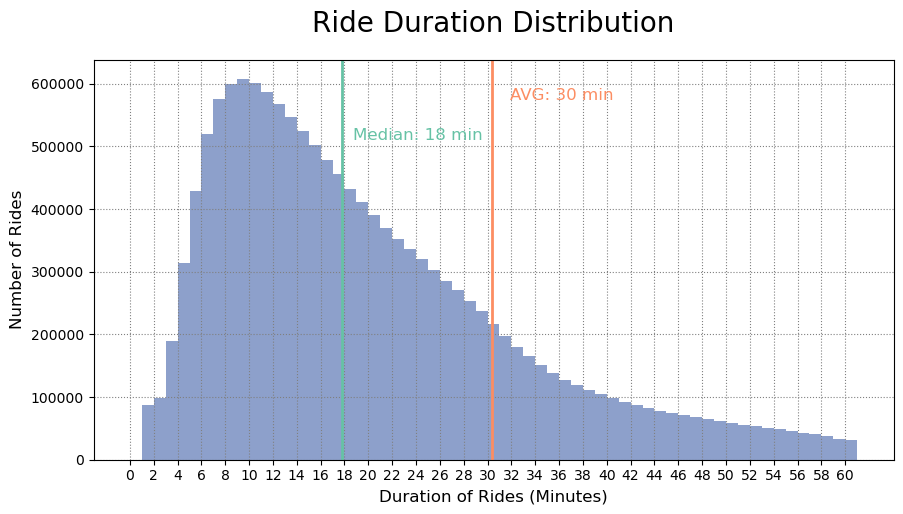

In [8]:
# Filtering relevant data
duration_data = df_bike_trip["duration"]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Ploting the histogram
plt.hist(duration_data, bins = range(62), color = COLOR_PALETTE[2], histtype ="bar")

# Adding median and mean lines
plt.axvline(df_bike_trip["duration"].mean(), color=COLOR_PALETTE[1], linestyle='-', linewidth=2 )
plt.axvline(df_bike_trip["duration"].median(), color=COLOR_PALETTE[0], linestyle='-', linewidth=2 )
#plt.axvline(x = 30, color="blue", linestyle='-', linewidth=1 )

# Adding median and mean texts
min_ylim, max_ylim = plt.ylim()
plt.text(df_bike_trip["duration"].mean()*1.05, max_ylim*0.9, 'AVG: {:.0f} min'.format(df_bike_trip["duration"].mean()), color = COLOR_PALETTE[1],  fontsize= 12)
plt.text(df_bike_trip["duration"].median()*1.05, max_ylim*0.8, 'Median: {:.0f} min'.format(df_bike_trip["duration"].median()), color = COLOR_PALETTE[0], fontsize= 12)
#plt.text(x= 28,y=200000, s="Free", color = GREEN, fontsize= 12)
#plt.text(x= 30.5,y=200000, s="Extra Charge", color = "grey", fontsize= 12)

# Seting ticks on x axis
ticks =range(0, 62, 2)
plt.xticks(ticks)
# Seting ticks on y axis
ticks =range(0, 3600, 2000)

# Labeling Axes
ax.set_title('Ride Duration Distribution', fontdict={"fontsize":20}, pad = 20)
plt.xlabel("Duration of Rides (Minutes)", fontsize= 12, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 12)

# Adding Grid
plt.grid(linestyle=":", color='grey')


plt.show()

As we can see bellow the median ride duration has slightly decrease in the last years, as well the variance. Since 2020, Buenos Aires council has been charging a minimal amount for the service if you excide 30 minitues on the ride.

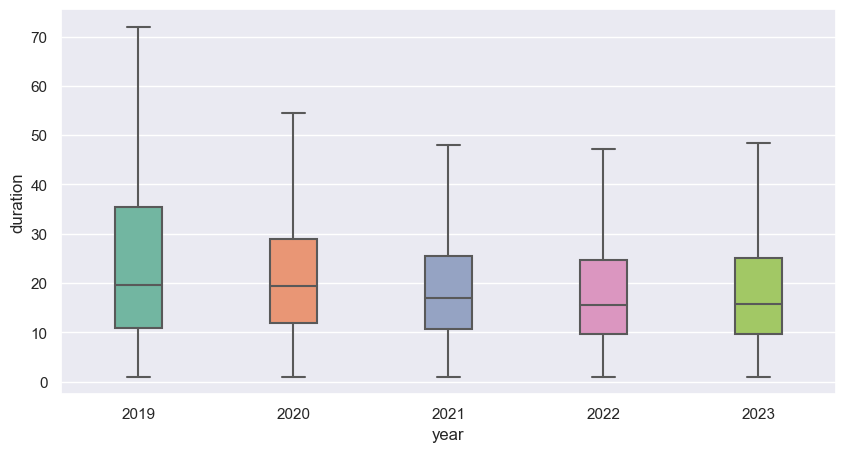

In [56]:
sns.set(rc={"figure.figsize":(10, 5)}) #width=6, height=5

sns.boxplot(x=df_bike_trip["year"], y=df_bike_trip["duration"], width=0.3, showfliers=False, palette=COLOR_PALETTE);
plt.show()

# 5. Bicycle trips

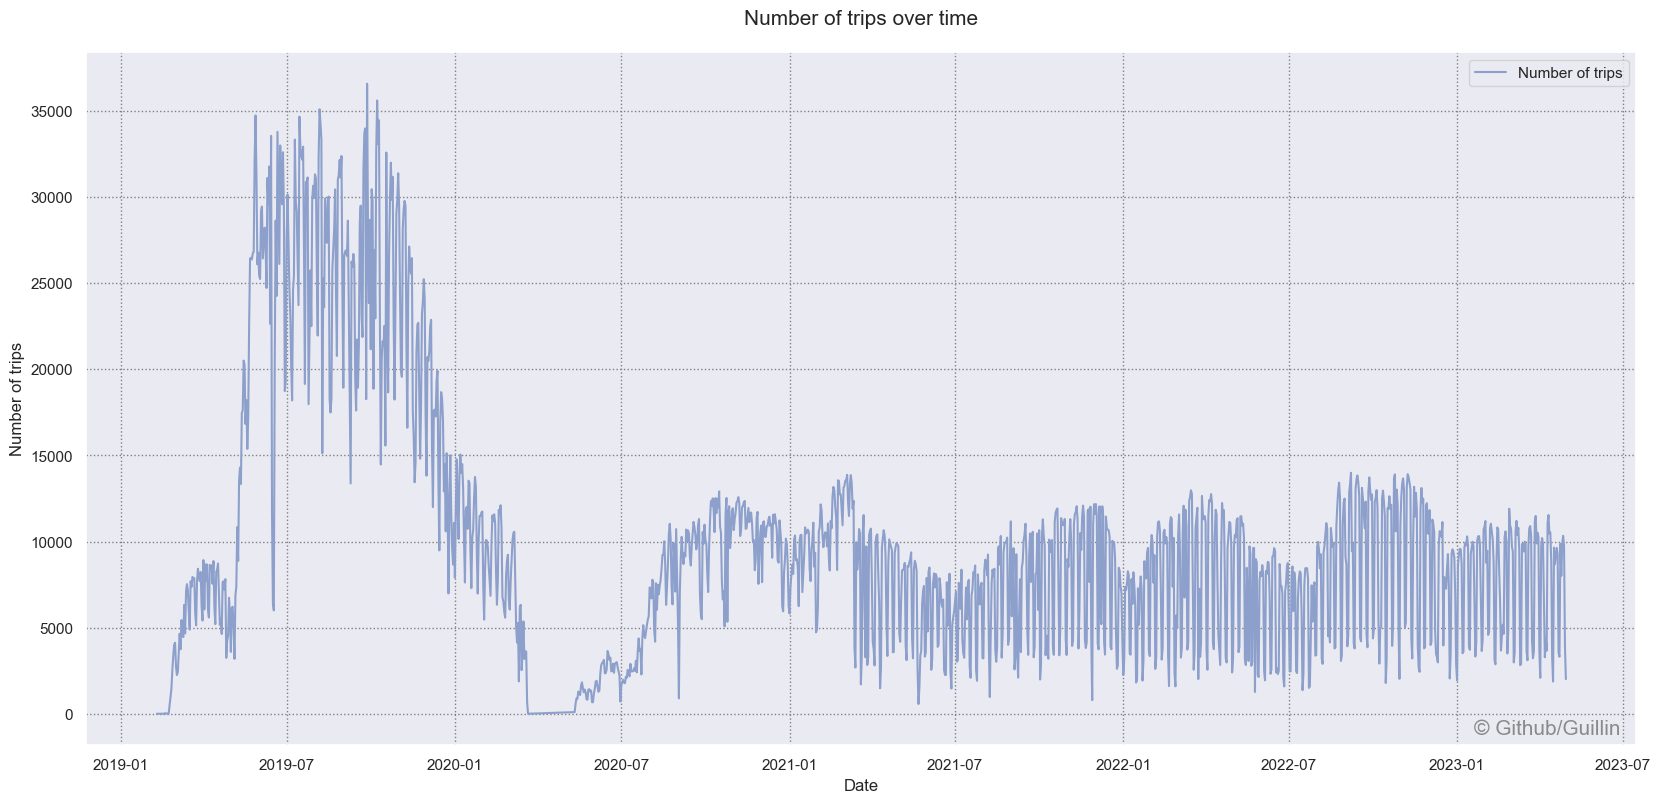

In [172]:
#    Number of trips over the years
df_over_time = df_bike_trip.groupby(df_bike_trip['departure'].dt.date).size().reset_index(name='count')

# Figure
fig, ax = plt.subplots(figsize=(20,9))
plt.plot(df_over_time["departure"], df_over_time["count"], color= COLOR_PALETTE[2])

# Labels
ax.set_title("Number of trips over time", fontsize= 15, pad= 20)
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

# Grid & Legend
plt.grid(linestyle=":", color='grey')
plt.legend(["Number of trips"])

# Watermark
ax.text(0.99, 0.01, '© Github/Guillin',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='grey',
        fontsize=15,
        alpha = 0.9)

plt.show()

Above we can see the number of daily bike trips from 2019 to middle 2023. The number of trips in 2019 was twice as much than we have had in the last years.
It is also visible that 2020 was the first year when bike usage declined. There are multiple possible explanations. This decrease can be due to the COVID-19 pandemic, new style of work or because the city bike network reached the end of its growth phase and many bike station were closed (almost 100).
We also can see the seasonal effect, where the number of rides reaches the pick in the Spring and the lowes values in winter.

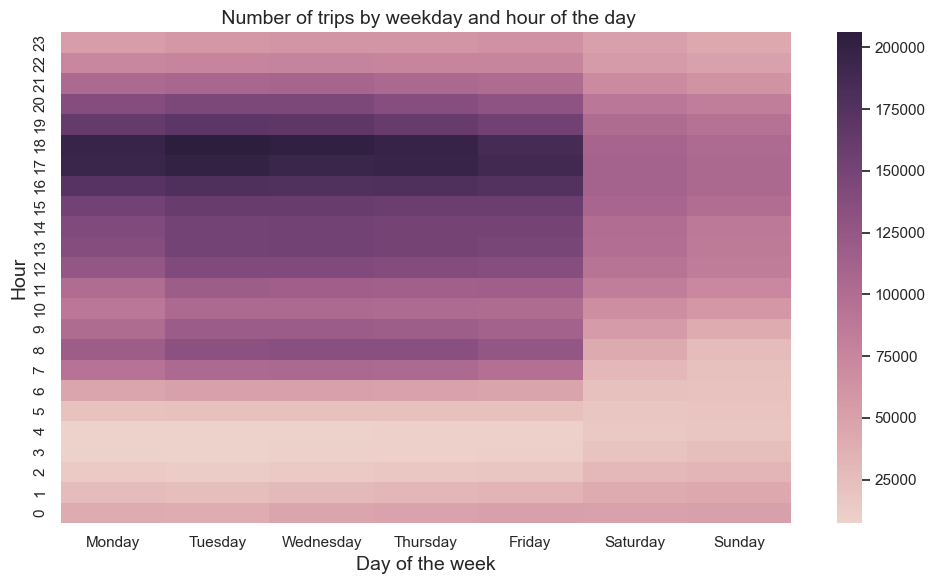

In [13]:
df_bike_trip["weekday"] = df_bike_trip.departure.dt.day_name()
df_bike_trip["hour"] = df_bike_trip.departure.dt.hour
df_dayly_act = df_bike_trip.groupby(["weekday", "hour"],sort=False).size().reset_index(name='count')
heatmap_dayly_act = pd.pivot_table(df_dayly_act, values='count', index=['hour'], columns='weekday')
heatmap_dayly_act = heatmap_dayly_act[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
heatmap_dayly_act.sort_index(ascending=False, inplace=True)


sns.set(rc={"figure.figsize":(10, 6)})
sns.heatmap(heatmap_dayly_act, cmap=sns.cubehelix_palette(as_cmap=True))
plt.xlabel("Day of the week", size=14)
plt.ylabel("Hour", size=14)
plt.title(" Number of trips by weekday and hour of the day", size=14)
plt.tight_layout()


#plt.savefig('heatmap_with_Seaborn_python.jpg',dpi=150, figsize=(9,6))

If we look at the heatmap above we can see a well-established daily usage pattern. The Most intensive bike usage occurs from 6:00 to 8:00 and from 16:00 to 18:00 on weekdays. This shows that bikes are actively used by users at the beginning and the end of the working day.

[Text(0.5, 154.24999999999997, 'Time of the day (Hours)'),
 Text(1162.8382352941178, 0.5, 'Day of the week')]

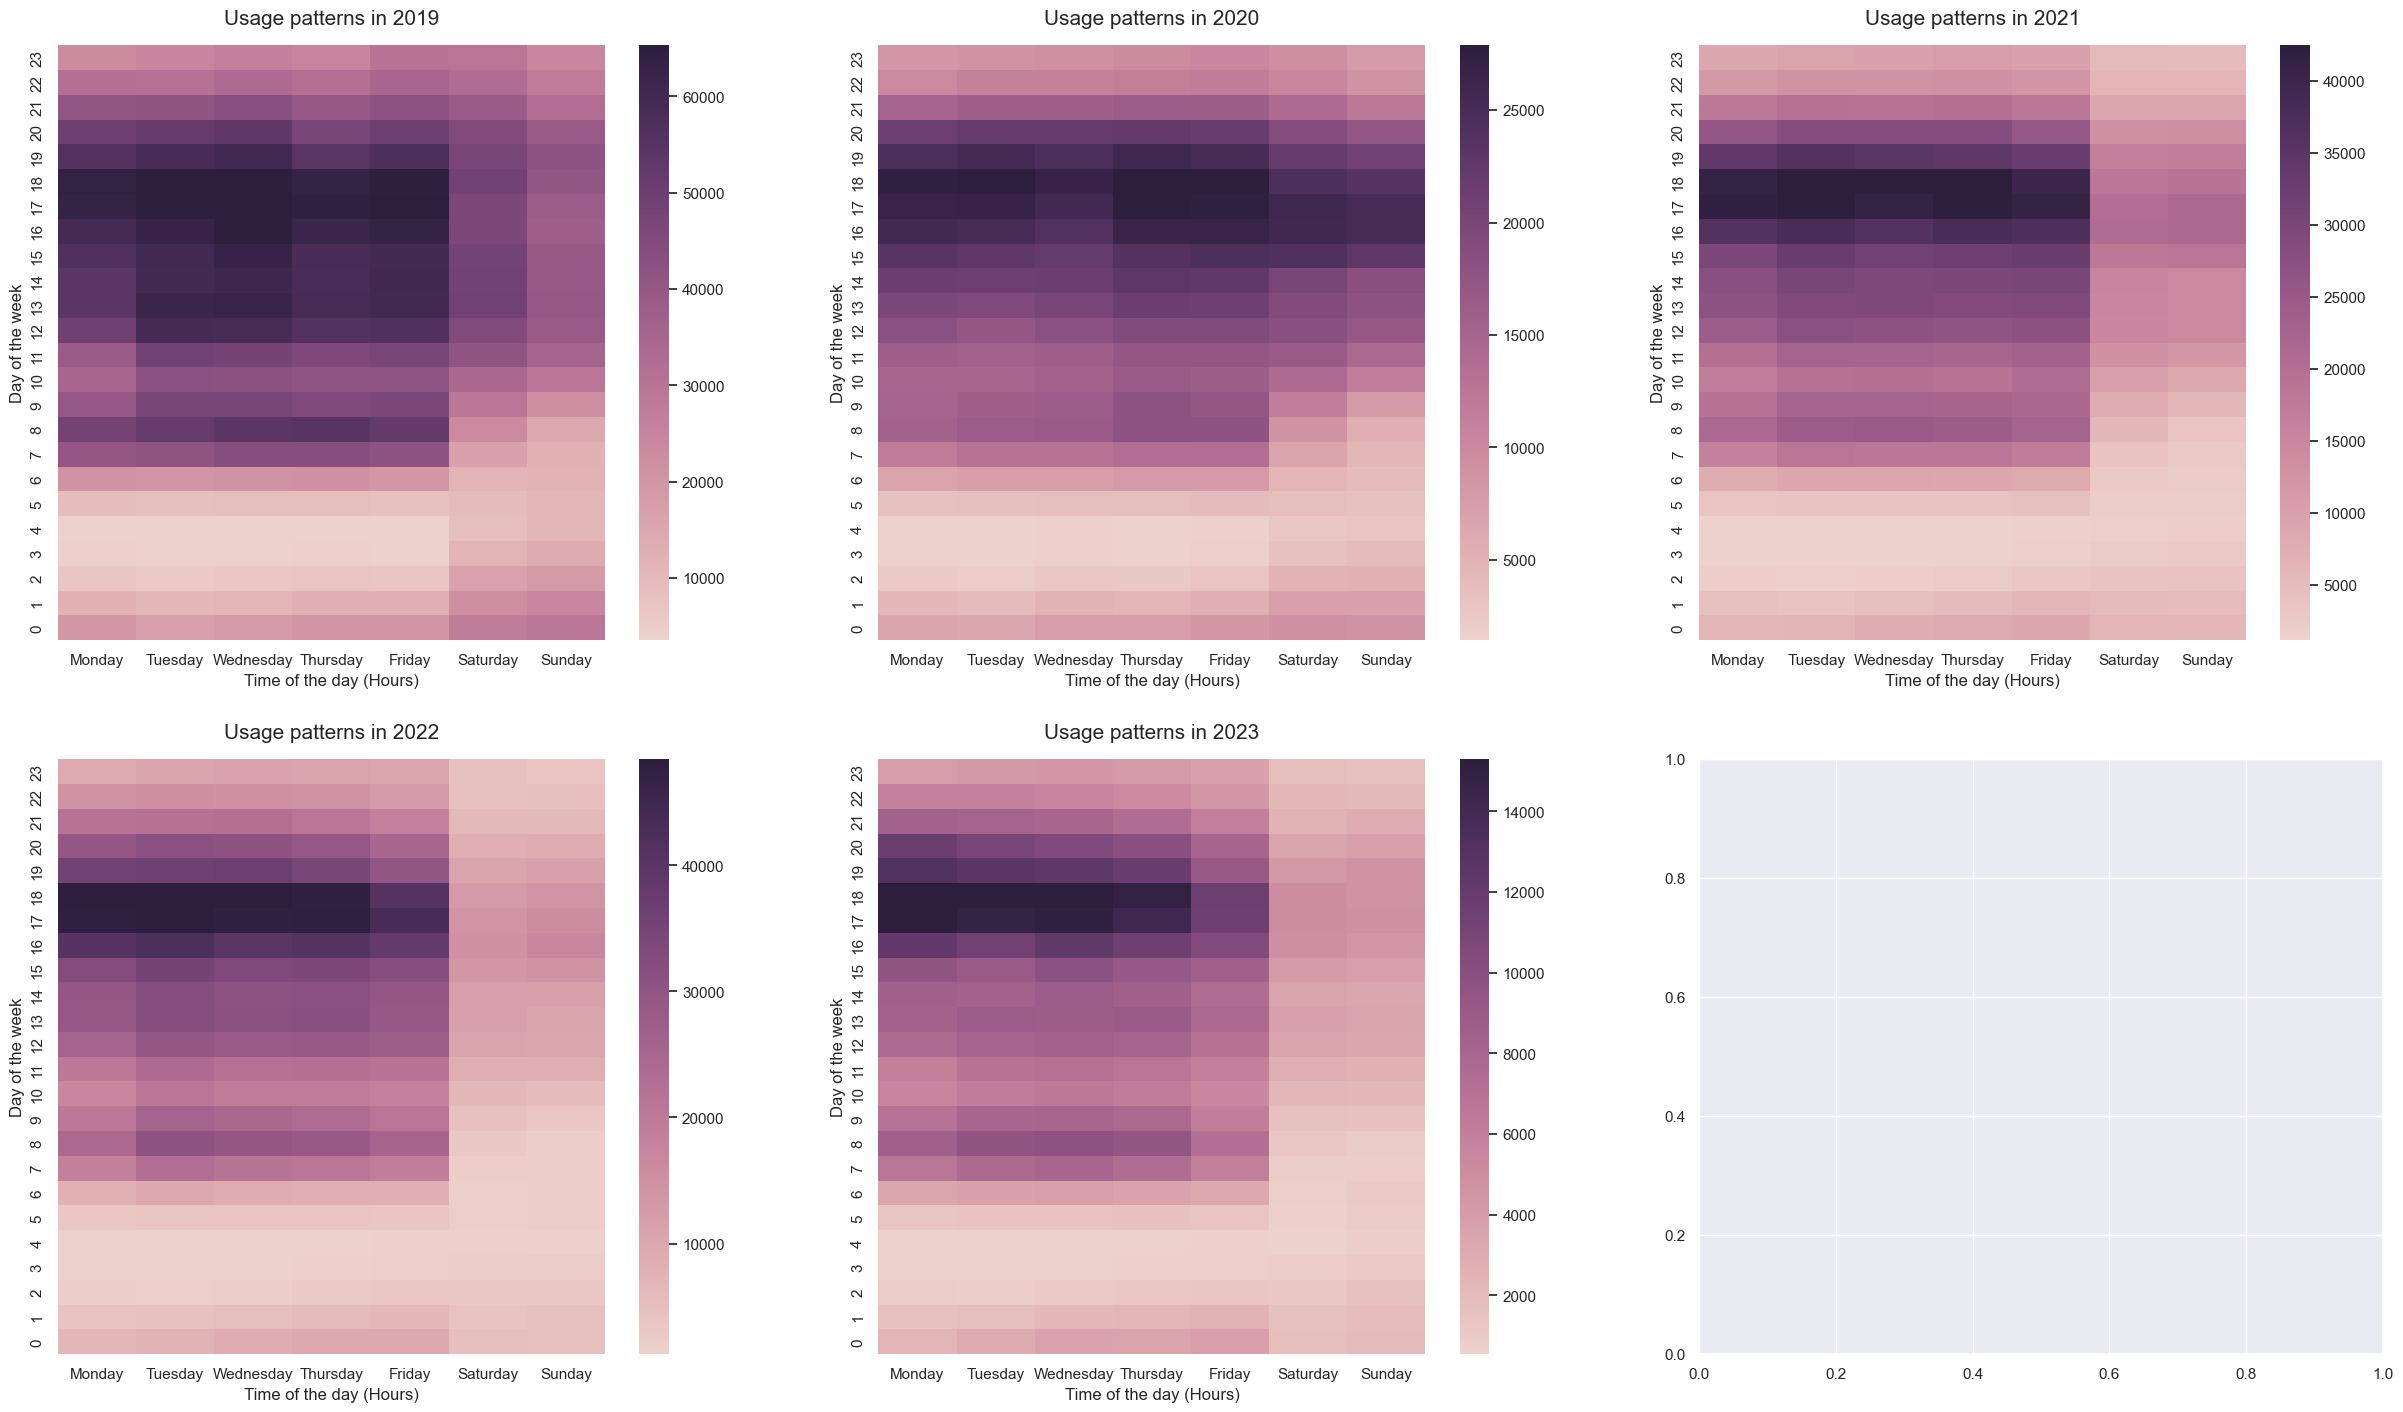

In [14]:
df_dayly_act = df_bike_trip.groupby(["year","weekday", "hour"],sort=False).size().reset_index(name='count')


# Figure
fig, axs = plt.subplots(2, 3,figsize=(30,17))

df_dayly_act_y2019 = pd.pivot_table(df_dayly_act[df_dayly_act["year"]==2019], values='count', index=['hour'], columns='weekday')
df_dayly_act_y2019 = df_dayly_act_y2019[WEEKDAYS].sort_index(ascending=False)

df_dayly_act_y2020 = pd.pivot_table(df_dayly_act[df_dayly_act["year"]==2020], values='count', index=['hour'], columns='weekday')
df_dayly_act_y2020 = df_dayly_act_y2020[WEEKDAYS].sort_index(ascending=False)

df_dayly_act_y2021 = pd.pivot_table(df_dayly_act[df_dayly_act["year"]==2021], values='count', index=['hour'], columns='weekday')
df_dayly_act_y2021 = df_dayly_act_y2021[WEEKDAYS].sort_index(ascending=False)

df_dayly_act_y2022 = pd.pivot_table(df_dayly_act[df_dayly_act["year"]==2022], values='count', index=['hour'], columns='weekday')
df_dayly_act_y2022 = df_dayly_act_y2022[WEEKDAYS].sort_index(ascending=False)

df_dayly_act_y2023 = pd.pivot_table(df_dayly_act[df_dayly_act["year"]==2023], values='count', index=['hour'], columns='weekday')
df_dayly_act_y2023 = df_dayly_act_y2023[WEEKDAYS].sort_index(ascending=False)


sns.heatmap(df_dayly_act_y2019, ax=axs[0][0], robust=True, cmap=COLORMAP)
sns.heatmap(df_dayly_act_y2020, ax=axs[0][1], robust=True, cmap=COLORMAP)
sns.heatmap(df_dayly_act_y2021, ax=axs[0][2], robust=True, cmap=COLORMAP)
sns.heatmap(df_dayly_act_y2022, ax=axs[1][0], robust=True, cmap=COLORMAP)
sns.heatmap(df_dayly_act_y2023, ax=axs[1][1], robust=True, cmap=COLORMAP)

# Labeling Axes
axs[0][0].set_title("Usage patterns in 2019", fontsize= 15, pad = 15)    
axs[0][1].set_title("Usage patterns in 2020", fontsize= 15, pad = 15)
axs[0][2].set_title("Usage patterns in 2021", fontsize= 15,pad = 15)
axs[1][0].set_title("Usage patterns in 2022", fontsize= 15, pad = 15)
axs[1][1].set_title("Usage patterns in 2023", fontsize= 15,pad = 15)

axs[0][0].set(xlabel="Time of the day (Hours)", ylabel="Day of the week")
axs[0][1].set(xlabel="Time of the day (Hours)", ylabel="Day of the week")
axs[0][2].set(xlabel="Time of the day (Hours)", ylabel="Day of the week")
axs[1][0].set(xlabel="Time of the day (Hours)", ylabel="Day of the week")
axs[1][1].set(xlabel="Time of the day (Hours)", ylabel="Day of the week")

As we have seen in previous graphs, there are some difference in the bike usage patterns. Besides the decrease in the overall bike usage, the number of trips during the rush hours has also decreased.


# 6. User ride activity.
Let's now analyse the data from the user perspective.

Text(0.5, 0, 'Date')

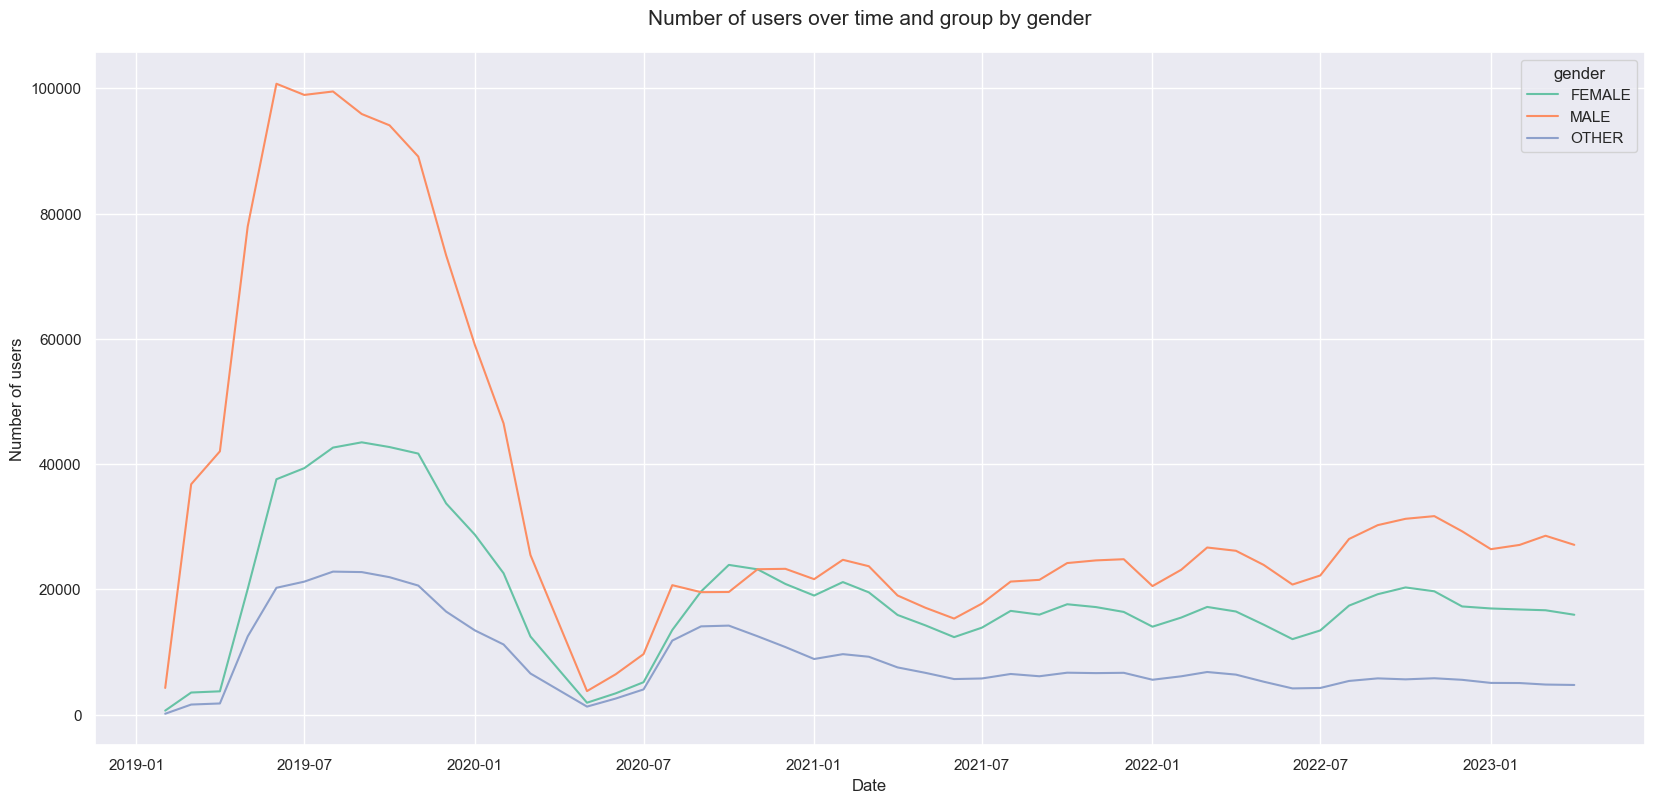

In [177]:
df_over_time_gender = df_bike_trip.groupby([df_bike_trip['departure'].astype('datetime64[M]'), "gender"]).user_id.nunique().reset_index(name='count')


#define figure size
sns.set(rc={"figure.figsize":(20, 9)})

ax = sns.lineplot(data=df_over_time_gender, x="departure", y="count", hue="gender", palette=COLOR_PALETTE[:3])

# Labels
ax.set_title("Number of users over time and group by gender", fontsize= 15, pad= 20)
ax.set_ylabel("Number of users", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

By the middle of 2019 we had the most number of active users (Male:100740, Female:37592, Other:20262 -> 158594), however, since the middle of 2020 this number has droped to its lowes value and it has slightly recovered to 37K active users.
As we can see from the chart below, males tend to make more trips on bikes than females. 

Text(0.5, 0, 'Date')

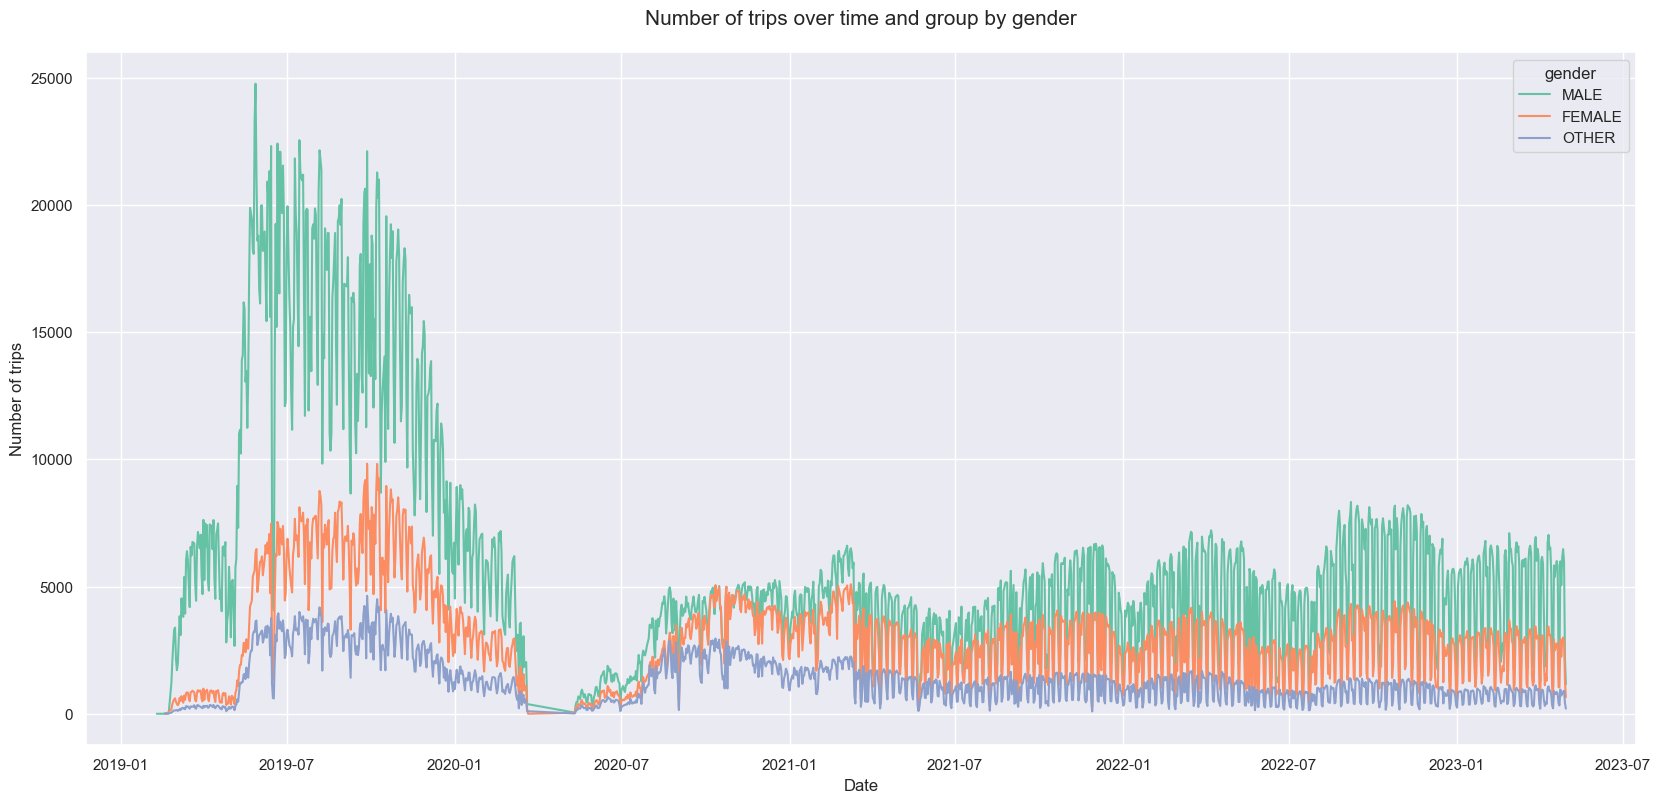

In [ ]:
df_over_time_gender = df_bike_trip.groupby([df_bike_trip['departure'].dt.date, "gender"]).size().reset_index(name='count')


#define figure size
sns.set(rc={"figure.figsize":(20, 9)})
palette = sns.color_palette("mako_r", 3)

ax = sns.lineplot(data=df_over_time_gender, x="departure", y="count", hue="gender", palette=COLOR_PALETTE[:3])

# Labels
ax.set_title("Number of trips over time and group by gender", fontsize= 15, pad= 20)
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

From the box-plots below, we can see there is not a huge difference on ride duration between genders

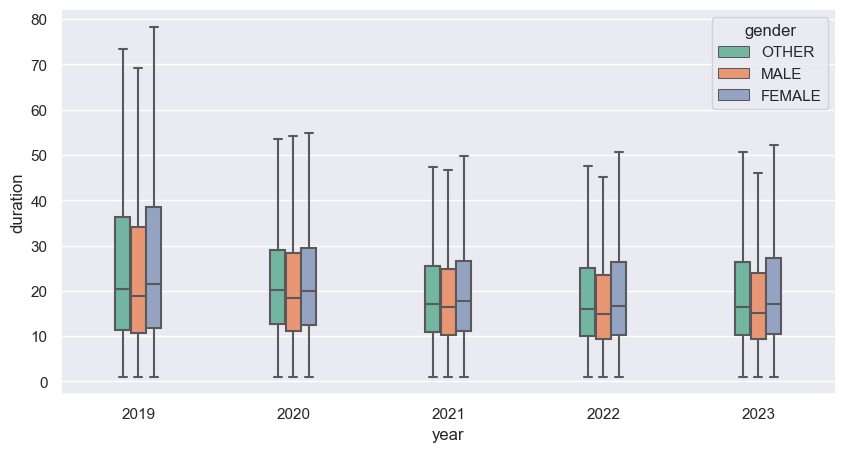

In [184]:
sns.set(rc={"figure.figsize":(10, 5)}) #width=6, height=5

sns.boxplot(data=df_bike_trip , x="year", y="duration", hue="gender", width=0.3, showfliers=False, palette=COLOR_PALETTE);
plt.show()

We can conclude from previous graphs that males are the main users of this service, but we can't confirm it without taking into account the population distribution of buenos aires. Within the category `Others` it includes those that they don't belong to the previous groups or don't share this information. So, the conclusion could be skewed.

# 7. Bicycle Stations

Bike stations are spreaded in the whole city, but most of them are concentrated in specific areas where most people live and work. Let's look how stations are situated in the city and how they have changed over the years. 
As we've mentioned before, the number the bike stations has changed over the years. We started in 2019 with 412 bike stations, then in 2020 a few were closed and in the following year we ended up with only 250. Then, in the last two years the number has risen once more, reaching 321 bike stations.

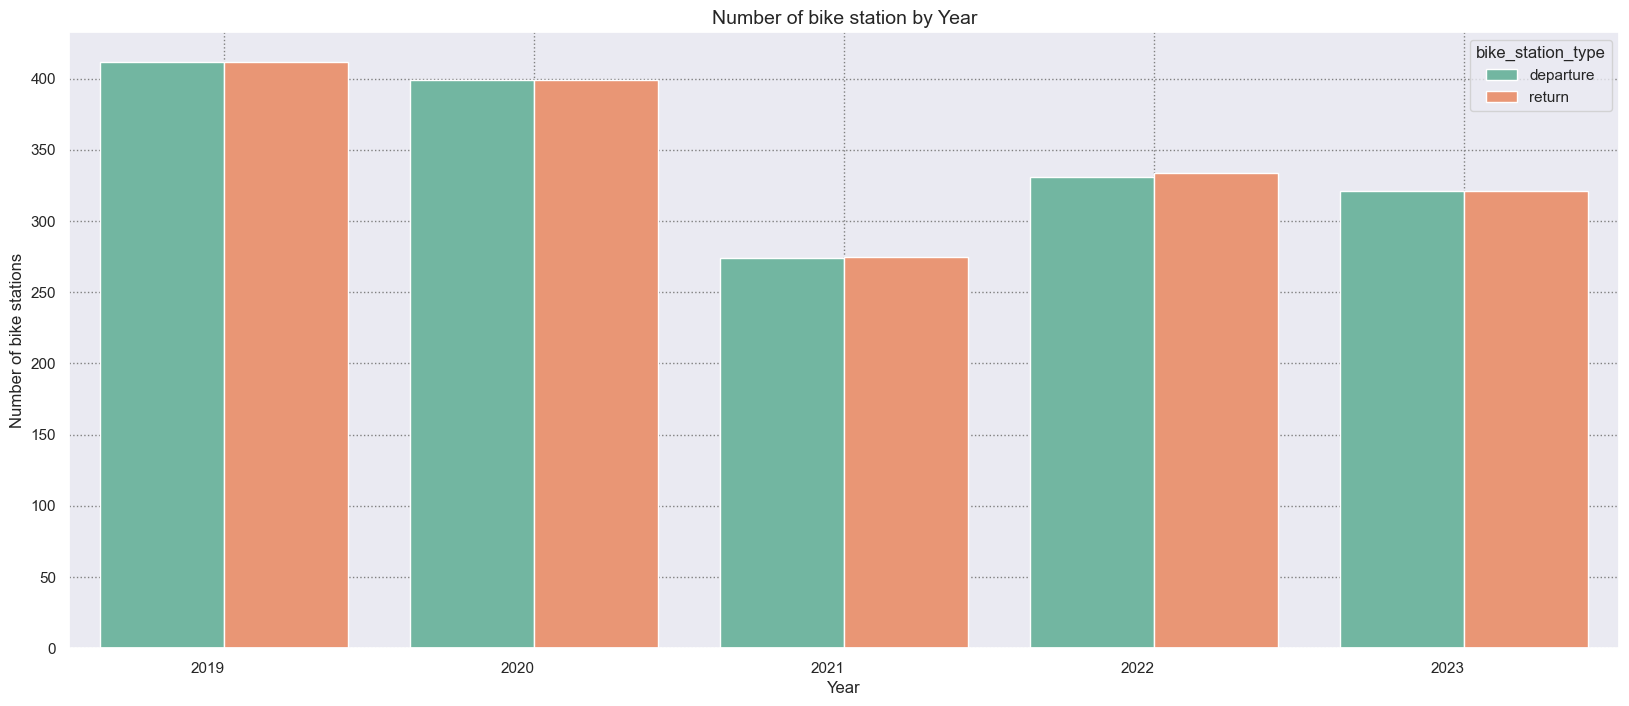

In [18]:
df_bike_station_counter = df_bike_trip.groupby("year")[['departure_station_id', 'return_station_id']].nunique().reset_index()
df_bike_station_counter.columns = ['year', 'departure', 'return']
df_bike_station_counter = df_bike_station_counter.melt('year', var_name='bike_station_type', value_name='count_bike_station')


# Figure
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'year',
      y = 'count_bike_station',
      data = df_bike_station_counter,
      palette=COLOR_PALETTE,
      hue='bike_station_type',
      ci = 0)

      
# Labeling Axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.xlabel("Year", fontsize= 12, x = 0.5)
plt.ylabel("Number of bike stations", fontsize= 12)
plt.title("Number of bike station by Year", size=14)


# Adding Grid
plt.grid(linestyle=":", color='grey')
   

In [ ]:
df_bike_station = df_bike_trip[["year", "departure_station_id", "departure_station_name","departure_long", "departure_lat"]].drop_duplicates()
df_bike_station["period"] = df_bike_station["year"].apply(lambda x : pd.to_datetime(f"{x}-12-01"))

with open( "config/bike_station_confmap.json")as f:
    mapconfig = json.load(f)

map_bike_station = KeplerGl(height=600,  data={"Bike shareing BA": df_bike_station, "neighborhoods": neighborhoods})
map_bike_station.config = mapconfig
map_bike_station.save_to_html()

plotKeplerMap(map_bike_station, height=600)

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Bike shareing BA'], 'id': '…

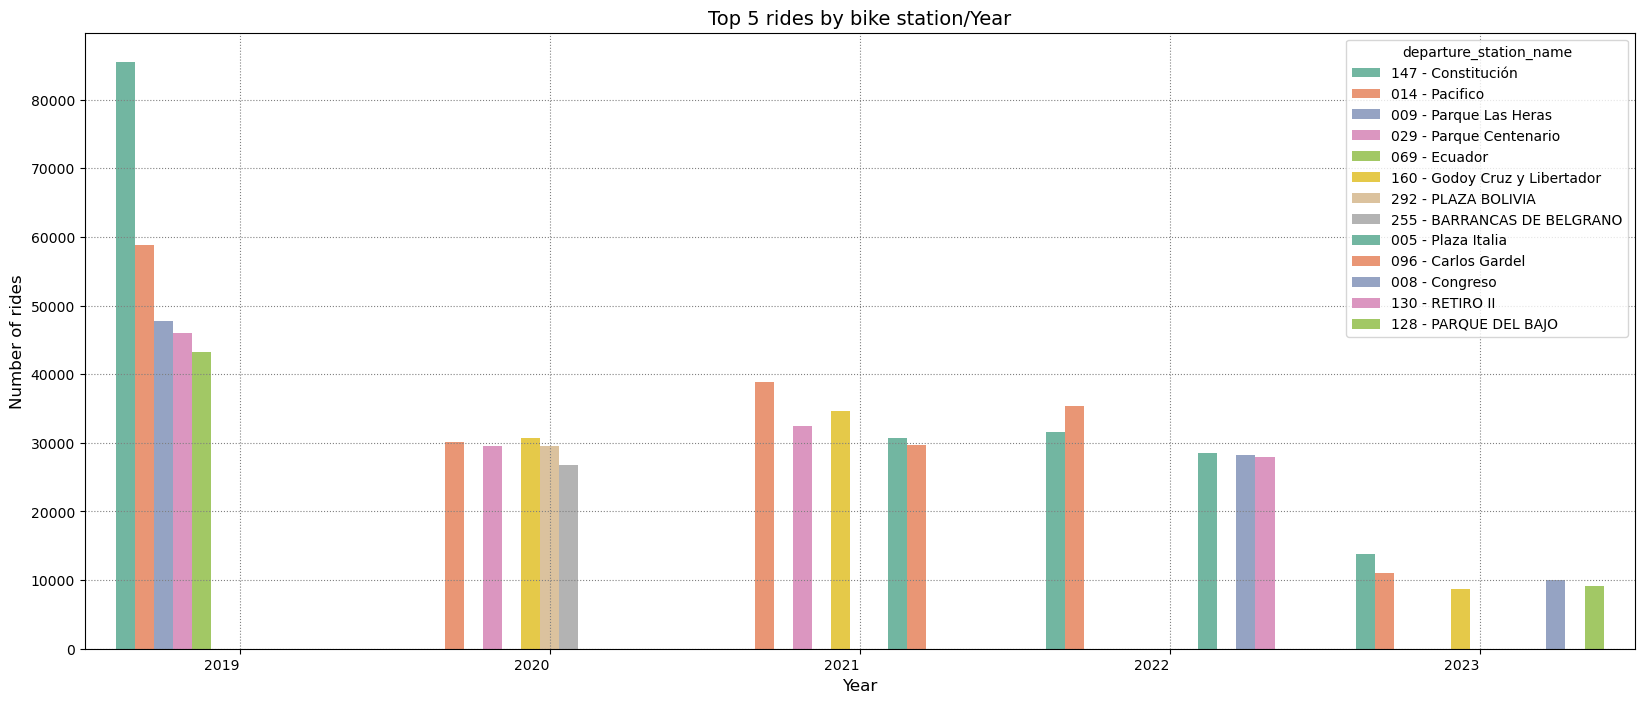

In [84]:
top5_station_year = df_bike_trip.groupby(["year"])["departure_station_name"].value_counts().groupby(level=0, group_keys=False).head(5)
top5_station_year = top5_station_year.to_frame()
top5_station_year.columns = ["count"]
top5_station_year = top5_station_year.reset_index()

# Figure
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'year',
      y = 'count',
      data = top5_station_year,
      palette=COLOR_PALETTE,
      hue='departure_station_name')

      
# Labeling Axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.xlabel("Year", fontsize= 12)
plt.ylabel("Number of rides", fontsize= 12)
plt.title("Top 5 rides by bike station/Year", size=14)


# Adding Grid
plt.grid(linestyle=":", color='grey')
   

As one might expect, not all stations are used equally. In 2019 the station `Constitucion` was the most popular one. However, from 2020 to 2022 `Pacifico` has become the most used. If we look at `Constitucion` and `Retiro II` these are the top 5 as explained by their location next to the rail station. 
One boundary condition that can affect this list is bike availability in a given station. If there are no bikes available, then the dataset will not reflect the demand for bikes but rather their availability. What makes these stations evenly is that they are popular stations for both departures and returns. This ensures bike availability at all times and increases station usage. Bear in mind that some bike stations have changed their names over the years, so we might be refering to the same bike stations.
Let's see now what are the top 20 departure and return.

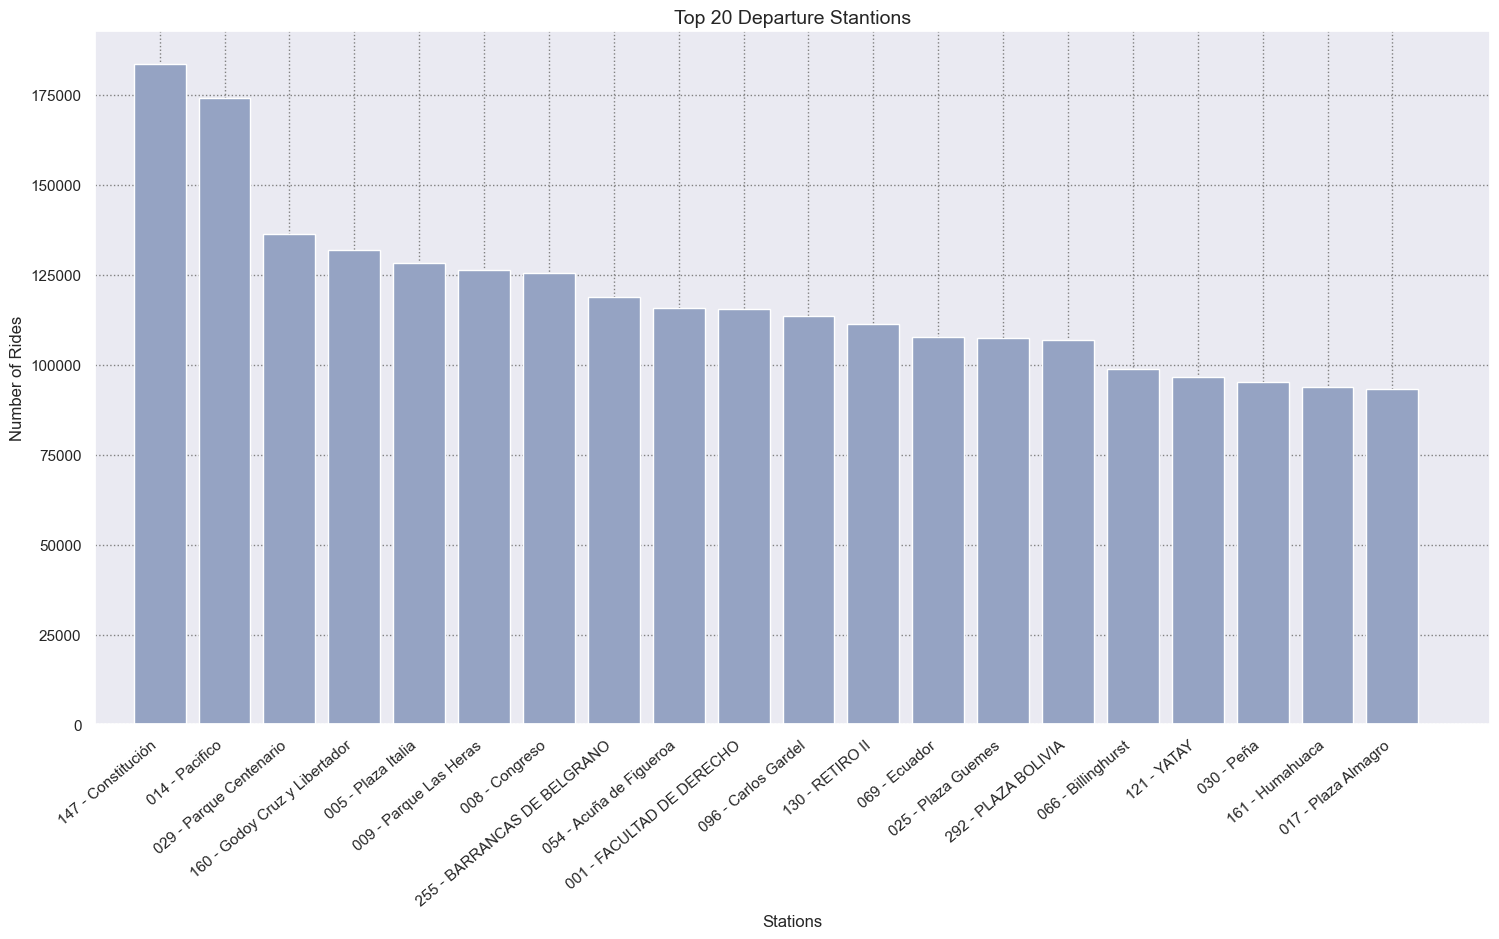

In [88]:
top_departure_station = df_bike_trip.groupby("departure_station_name").size().reset_index(name='count')\
                                    .sort_values("count", ascending=False).iloc[:20, :]
# Figure
fig = plt.figure(figsize=(18, 9))
ax = sns.barplot(x = 'departure_station_name',
      y = 'count',
      data = top_departure_station,
      estimator = np.sum,
      color=COLOR_PALETTE[2],
      ci = 0)

      
# Labeling Axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel("Stations", fontsize= 12, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 12)
plt.xlim(-1,20.5)
plt.title("Top 20 Departure Stantions", size=14)


# Adding Grid
plt.grid(linestyle=":", color='grey')

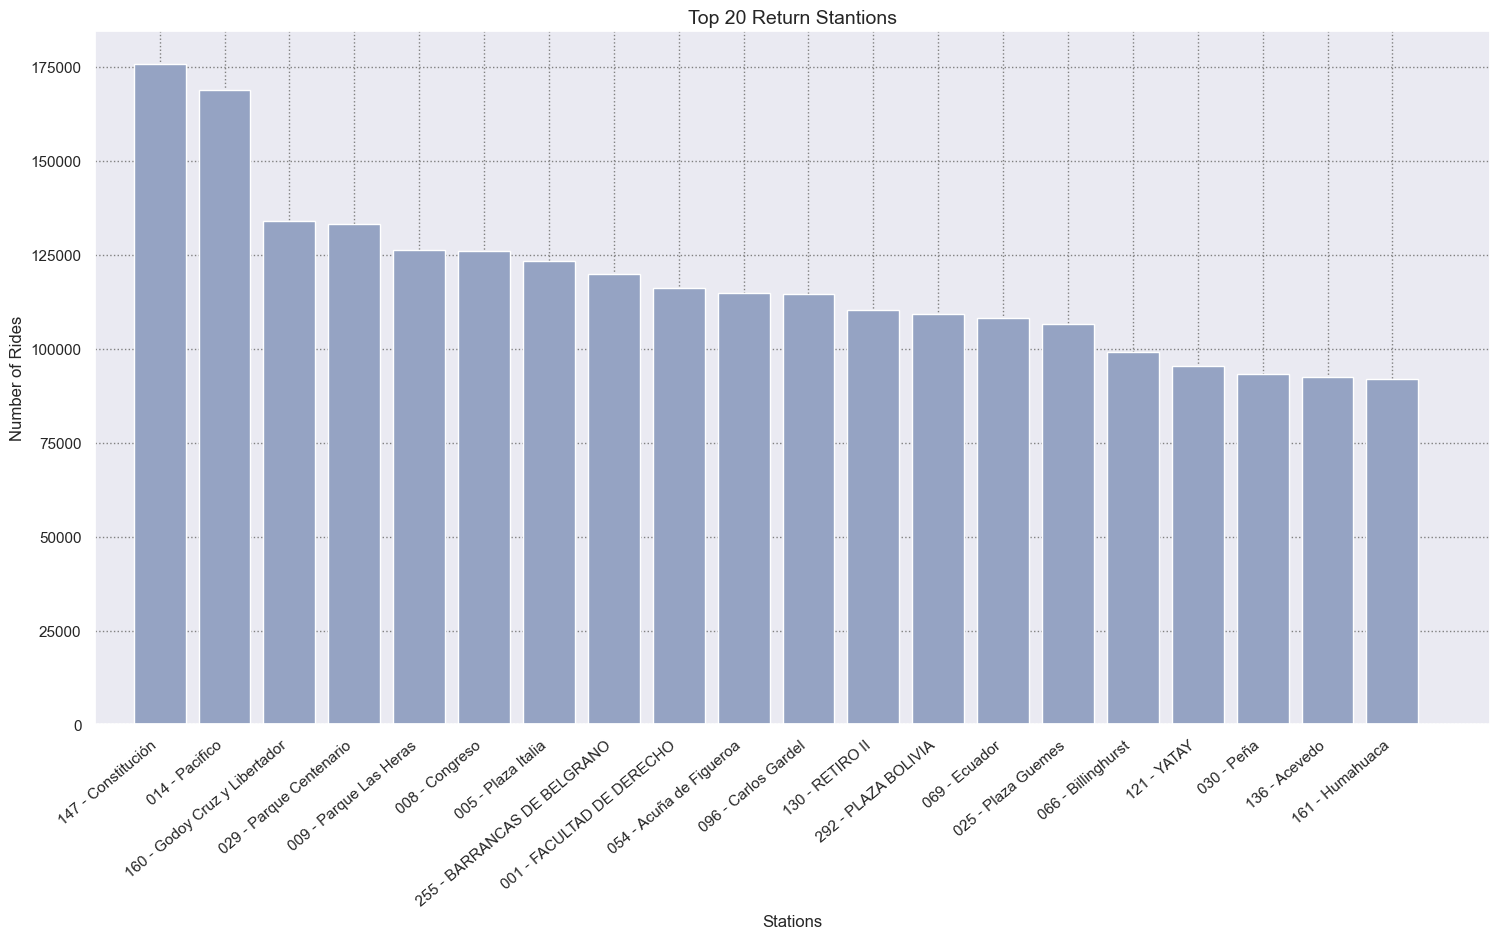

In [89]:
top_return_station = df_bike_trip.groupby("return_station_name").size().reset_index(name='count')\
                                    .sort_values("count", ascending=False).iloc[:20, :]
# Figure
fig = plt.figure(figsize=(18,9))
ax = sns.barplot(x = 'return_station_name',
      y = 'count',
      data = top_return_station,
      estimator = np.sum,
      color=COLOR_PALETTE[2],
      ci = 0)

      
# Labeling Axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel("Stations", fontsize= 12, x = 0.5)
plt.ylabel("Number of Rides", fontsize= 12)
plt.xlim(-1,20.5)
plt.title("Top 20 Return Stantions", size=14)


# Adding Grid
plt.grid(linestyle=":", color='grey')
   

The heatmaps below illustrate the origin-destination pairs and the frequency of their occurrence from 2019 to 2023. We can see some patters like `Barrancas de belgrano`  with `Tamborini`, `Eduardo Olivera` and `Plaza Paso`. Eventhough, it is hard to find the relationships between departure and return stations in this kind of graph.

Text(229.74999999999997, 0.5, 'Origin Name')

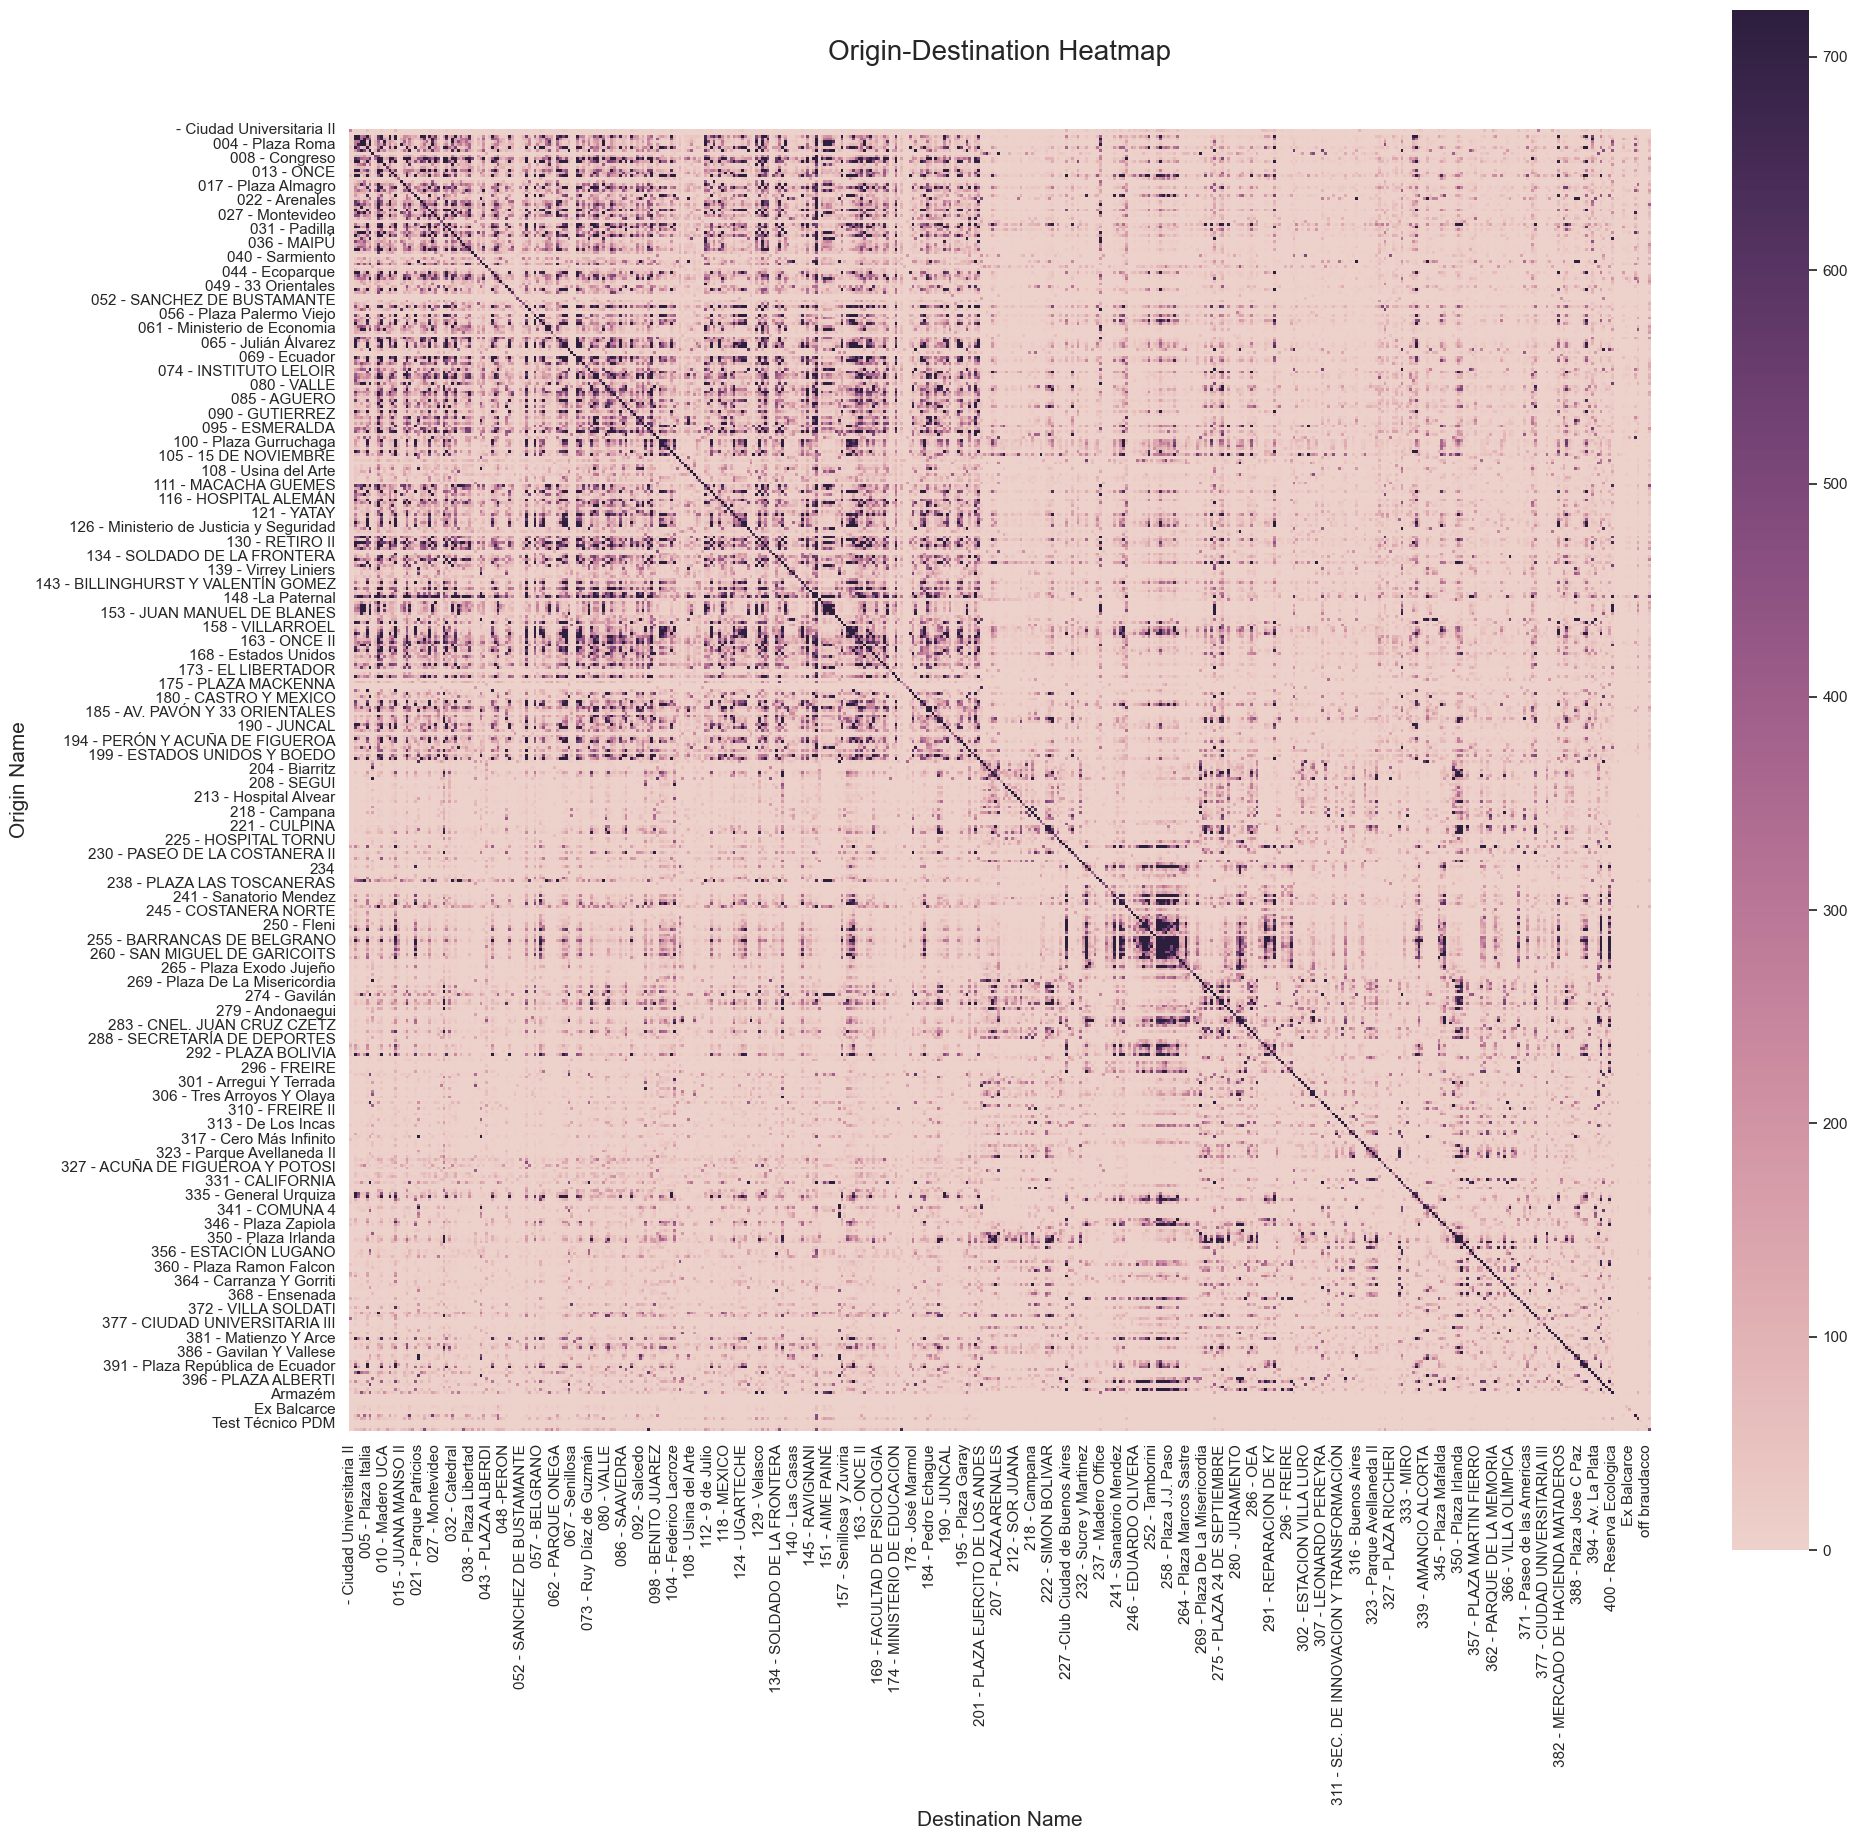

In [99]:
origin_destination_crosstab = pd.crosstab(df_bike_trip['departure_station_name'],
                            df_bike_trip['return_station_name'], 
                               margins = False)

# Figure
fig, ax = plt.subplots(figsize=(21,20))
sns.heatmap(origin_destination_crosstab, robust=True, cmap=COLORMAP ,square=True)

# Labeling
ax.set_title('Origin-Destination Heatmap', fontdict={"fontsize":20}, pad = 50)
ax.set_xlabel("Destination Name", fontsize= 15, x = 0.5)
ax.set_ylabel("Origin Name", fontsize= 15)

We mentioned before that bike station are not equally distributed by neighbourhood. Let's see how many stations have each neighbourhood.

In [86]:
df_bike_station = df_bike_trip[["departure_station_id", "departure_station_name","departure_long", "departure_lat"]]\
    .drop_duplicates(subset=['departure_long', 'departure_lat'], keep="first") # keep only one station per coord avoiding name changed over the years


bike_station_counter = {}
for neighborhood in tqdm(neighborhoods["features"]):
    bike_station_counter[neighborhood["properties"]["BARRIO"]] = 0
    poly = Polygon([tuple(p[::-1]) for p in neighborhood["geometry"]["coordinates"][0][0]])
    for index, row in df_bike_station.iterrows():
        bike_station_coord = Point(row["departure_lat"], row["departure_long"])

        if bike_station_coord.within(poly):
            bike_station_counter[neighborhood["properties"]["BARRIO"]] += 1
        

df_bike_station_counter = pd.DataFrame( {"neighborhood": list(bike_station_counter.keys()), 
                                         "count_bike_station":list(bike_station_counter.values())})

    

100%|██████████| 48/48 [00:01<00:00, 28.24it/s]


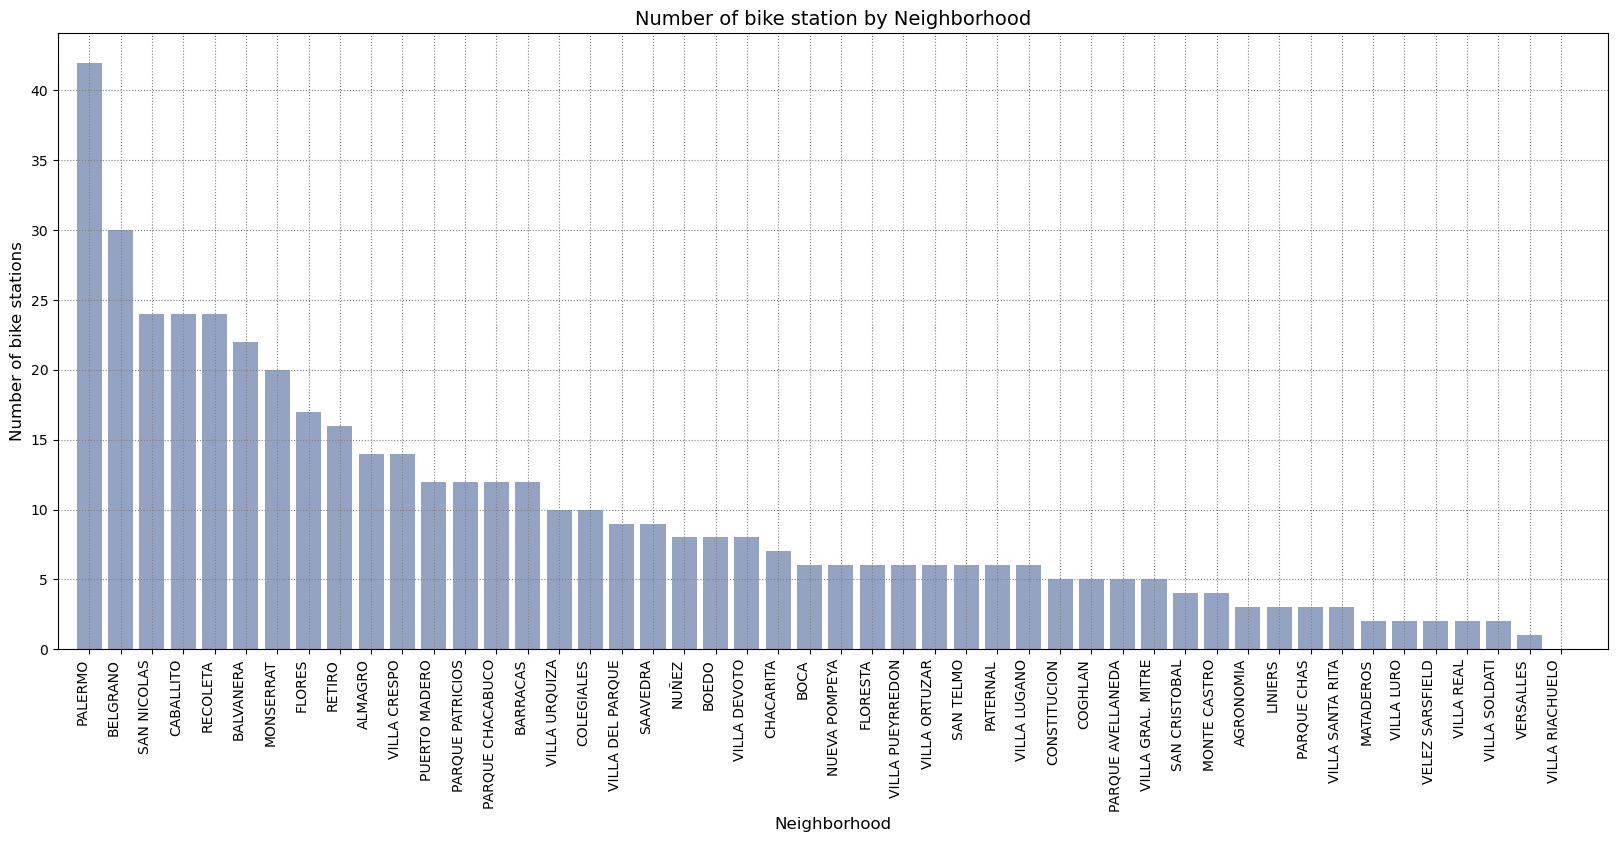

In [101]:
df_bike_station_counter.sort_values("count_bike_station", ascending=False, inplace=True)

# Figure
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'neighborhood',
      y = 'count_bike_station',
      data = df_bike_station_counter,
      color=COLOR_PALETTE[2],
      ci = 0)

      
# Labeling Axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.xlabel("Neighborhood", fontsize= 12, x = 0.5)
plt.ylabel("Number of bike stations", fontsize= 12)
plt.xlim(-1,48.5)
plt.title("Number of bike station by Neighborhood", size=14)


# Adding Grid
plt.grid(linestyle=":", color='grey')
   

From the bar graph above, we can see that `Palermo`, `Belgrano`, `San Nicolas`, `Caballito` and `Recoleta` are the neighbourhoods with more bike stations. They are also the most popular within the wealtiest suburbs in the city. There are some neighbourhood that only have one or none like `Villa Riachuelo`.

In [7]:
# aggregating data
# creating pairs
# if 457 station, then we make a lot of pairs.
origins = df_bike_trip['departure_station_id'].unique().tolist()
destins = df_bike_trip['return_station_id'].unique().tolist()

# creating pairs of trips
pairs_list=[]
for origin in origins:
    for destin in destins:
        stat_pair = (origin, destin)
        
        pairs_list.append(stat_pair)
routes_list = list(range(len(pairs_list)))
# dictionary with pairs and ID
routes_dict = dict(zip(pairs_list, routes_list))



# adding a columns with station pairs
df_bike_trip['pairs'] = [(orID, deID) for orID, deID in zip(df_bike_trip['departure_station_id'].to_list(),
                                                                  df_bike_trip['return_station_id'].to_list())]

df_bike_trip["path_id"] = df_bike_trip['pairs'].map(routes_dict)
df_bike_trip["path_id"] = df_bike_trip["path_id"].astype("category")
df_bike_trip = df_bike_trip.dropna()



df_bike_trips_agg = df_bike_trip.groupby("path_id").agg({"departure_station_name": "max", 
    "departure_long": "max", "departure_lat": "max", "return_station_name": "max", "return_station_long": "max", "return_station_lat": "max", "pairs": "count", "duration": "mean"
}).reset_index()

df_bike_trips_agg.columns = ['path_id', 'departure_station_name', 'departure_long', 'departure_lat',
       'return_station_name', 'return_station_long', 'return_station_lat', 'qtrips', 'duration_mean']


df_bike_trips_agg = df_bike_trips_agg.sort_values("qtrips", ascending=False).head(10000)
gc.collect()


0

# 7. Ride graphs visualization

In [8]:
with open( "config/ride_confmap.json") as f:
    config_map = json.load(f)

map_bike_trips = KeplerGl(height=600,  data={"Bike trips": df_bike_trips_agg}, config=config_map)
plotKeplerMap(map_bike_trips)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '9qgd88m', 'type': …

In this graph you can apreciate the number trips between earch stations where you will find that the main concentration are in the north and center city which are the most fluent subers. 

# Conclusion

to summarize we have pinpoint the most usege bike stations within the cities and also find what are the most frequent routes by the citizens. The next step will be to present and advance analysis on graph theory in regards to the routes that are most popular.